# Encodings

- None (baseline)
- Label
- One-hot
- One-hot with "rare" values
- Feature hashing with x features
- Target
- Likelihood
- Frequency
- Probability
- Cat2Vec
- Deep category embedding

### Sources:

- https://blog.myyellowroad.com/using-categorical-data-in-machine-learning-with-python-from-dummy-variables-to-deep-category-66041f734512

- https://blog.myyellowroad.com/using-categorical-data-in-machine-learning-with-python-from-dummy-variables-to-deep-category-42fd0a43b009

- https://openreview.net/pdf?id=HyNxRZ9xg

### Read data

In [1]:
input_dir, basename = '../../data/adult', 'adult'

In [65]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss

# AutoML
import sys
main_path = '../../'
sys.path.append(main_path + 'code/auto_ml')
sys.path.append(main_path + 'code/processing')
sys.path.append(main_path + 'code/functions')
sys.path.append(main_path + 'code/models')
sys.path.append(main_path + 'data')

%matplotlib inline
%load_ext autoreload
%autoreload 2

from auto_ml import AutoML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
D = AutoML(input_dir, basename)

### Quick visualization

In [62]:
D.show_feat_type()
D.get_data(processed=False).head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
Type,Numerical,Categorical,Numerical,Categorical,Numerical,Categorical,Categorical,Categorical,Categorical,Binary,Numerical,Numerical,Numerical,Categorical


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### One-hot with rare values management

threshold = n / uniques * coeff

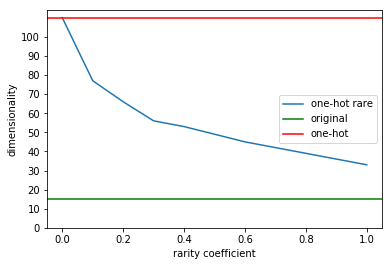

In [9]:
original = len(D.get_data().columns)

D.process_data(missing='most', code='one-hot', norm='none')
onehot = len(D.get_data(processed=True).columns)

x = np.arange(0, 1.1, 0.1)
y = []
for coeff in x:
    D.process_data(missing='most', code='one-hot', norm='none', rare=True, coeff=coeff)
    y.append(len(D.get_data(processed=True).columns))
    
import matplotlib.pyplot as plt

plt.plot(x, y, label='one-hot rare')
plt.xlabel('rarity coefficient')
plt.ylabel('dimensionality')
plt.yticks(np.arange(0, 110, 10))
plt.axhline(original, color='g', label='original')
plt.axhline(onehot, color='r', label='one-hot')
plt.legend()
plt.show()

In [106]:
encodings = ['label', 'one-hot', 'target', 'likelihood']
clfs = [LogisticRegression(), RandomForestClassifier(n_estimators=100)]

for encoding in encodings:
    
    print(encoding)
    D.process_data(missing='most', code=encoding, norm='none', target='age')

    X_train = D.get_data('X_train', processed=True)
    X_test = D.get_data('X_test', processed=True)

    if encoding in ['label', 'target', 'likelihood']:
        y_train = D.get_data('y_train', processed=True).values.ravel()
        y_test = D.get_data('y_test', processed=True).values.ravel()
        y_train = y_train.astype('int')
        y_test = y_test.astype('int')

    else:
        y_train = D.get_data('y_train', processed=True).as_matrix()
        y_train = np.argmax(y_train, axis=1)
        y_test = D.get_data('y_test', processed=True).as_matrix()
        y_test = np.argmax(y_test, axis=1)

    for clf in clfs:    
        print(clf)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        #print(classification_report(y_test, y_pred))
        print('Log loss: {}'.format(log_loss(y_test, y_pred)))
    
    print()
    print()

label
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Log loss: 7.223895907683689
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Log loss: 5.0121941584674445


one-hot
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verb